In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import math
import itertools
import CUDAPython as CP
%matplotlib inline

In [2]:
k = 10
m = 5

Generating single fermion energy levels:

In [3]:
def generate_energies(levels):
    '''generates array of k distinct energy levels'''
    energies = np.empty(levels)
    count=0
    while(count!=levels):
        energies[count]=normal(0,1)
        count+=1
    return energies

In [4]:
def sort_scale(array):
    '''scaling array to positive values and sorting it in ascending order'''
    min_ar = np.min(array)
    scaled_ar = array + abs(min_ar)
    return np.sort(scaled_ar)

In [5]:
arr = generate_energies(k)

In [6]:
arr_sorted = sort_scale(arr)
print(arr_sorted)

[0.         0.40802298 0.43229858 0.49207423 0.87267884 1.37526067
 1.37845372 1.50159921 1.74567469 2.22925011]


Text(0, 0.5, 'Energy level')

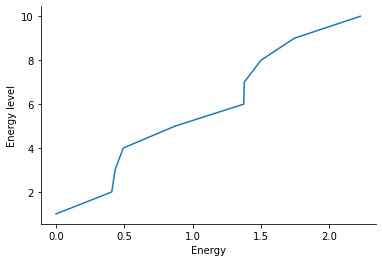

In [7]:
fig, axes = plt.subplots()
axes.plot(arr_sorted,np.linspace(1,k,k))
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('Energy')
axes.set_ylabel('Energy level')

Considering m fermions on k single fermion energy levels:

In [8]:
size = int(math.factorial(k)/((math.factorial(k-m))*(math.factorial(m))))

In [9]:
def permutations(state):
    '''returns possible permutations of a given binary state'''
    return list(set(itertools.permutations(state)))    

In [10]:
def ground_state(k, m):
    state = np.zeros(k, dtype=int)
    
    for i in range(m):
        state[i] = 1
    return state

In [11]:
state = ground_state(k, m)

In [12]:
state

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [13]:
states = permutations(state)

In [14]:
energy_state = {}
energies = np.empty(size)

In [15]:
for state in range(len(states)):
    energy = np.dot(states[state],arr_sorted)
    energies[state] = energy
    energy_state[energy] = states[state]

In [16]:
sorted_energies = np.sort(energies)

In [17]:
sorted_dict = {}

In [18]:
for energy in sorted_energies:
    sorted_dict[energy] = energy_state[energy]

Text(0, 0.5, 'Energy eigenvalues')

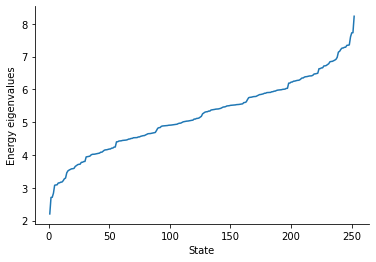

In [19]:
fig, axes = plt.subplots()
axes.plot(np.linspace(1,size,size),sorted_energies)
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('State')
axes.set_ylabel('Energy eigenvalues')

In [20]:
H_0 = np.zeros((size,size))

In [21]:
for i in range(size):
    H_0[i][i] = sorted_energies[i]

In [22]:
w = np.empty((size,size))

In [23]:
for i in range(size):
    for j in range(size):
        w[i][j] = normal(0,1)

In [24]:
w_T = np.transpose(w)

In [25]:
W = (w+w_T)/2 #ensuring that the random matrix is real and symmetric

In [26]:
H = H_0 + W #H is the hamiltonian with interactions due to the random matrix (non-diagonal)

Diagonalisation of H:

In [27]:
hCUDA = CP.CUDAContext() #obtain CUDA context (only 1 needed)

hCUBLAS = CP.CUBLASContext() 
hCUBLAS.Create() #create CUBLAS context (for basic linear algebra ops)

hCUSolverDense = CP.CUSolverDenseContext()
hCUSolverDense.Create() #create CUSolver Context (for dense matrix ops)

In [28]:
#allocating memory on the CPU to fit a matrix of size size X size
hHostMatrix = CP.CUDAHostMemory()
hHostMatrix.Allocate2D(CP.CUDANumericSizeRD, size, size, CP.CUDAHostMemoryAllocFlags.PINNED)

hHostVector = CP.CUDAHostMemory()
hHostVector.Allocate1D(CP.CUDANumericSizeRD, size, CP.CUDAHostMemoryAllocFlags.PINNED)

In [29]:
for i in range(size):
    for j in range(size):
        hHostMatrix.WriteRD(CP.CUDAMemoryPosition(i,j,0), H[i][j]) #initialising values

In [30]:
#allocating memory on the GPU to fit a matrix of size size X size
hDeviceMatrixA = CP.CUDADeviceMemory()
hDeviceMatrixA.Allocate2D(CP.CUDANumericSizeRD, size, size)

hDeviceVectorX = CP.CUDADeviceMemory()
hDeviceVectorX.Allocate1D(CP.CUDANumericSizeRD, size)

In [31]:
hCUBLAS.SetMatrix(hDeviceMatrixA, CP.CUDAMemoryPosition(), hHostMatrix, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size,size,1)) #copy memory from CPU to GPU
hCUDA.WaitForCurrentDevice() #sync

In [32]:
#build and setup of solver
hEigenSolver = CP.CUSolverDenseEigenValue(hCUSolverDense)
hEigenSolver.SetMatrixA(hDeviceMatrixA)
hEigenSolver.SetMatrixFillModeA(CP.CUBLASContextFillMode.UPPER)
hEigenSolver.SetVectorX(hDeviceVectorX)
hEigenSolver.SetAlgorithm(CP.CUSolverDenseEigenValueAlgorithm.QR) #householder reduction method???
hEigenSolver.ComputeEigenVectors(True)

In [33]:
hEigenSolver.PrepareRD() #allocates workspace memory

In [34]:
#solve and sync
hEigenSolver.SolveRD()
hCUDA.WaitForCurrentDevice()
hEigenSolver.UpdateStateAfterSync()

In [35]:
#copy memory from GPU to CPU
hCUBLAS.GetMatrix(hHostMatrix, CP.CUDAMemoryPosition(), hDeviceMatrixA, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size, size, 1))
hCUDA.WaitForCurrentDevice()

hCUBLAS.GetVector(hHostVector, CP.CUDAMemoryPosition(), hDeviceVectorX, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size, 1, 1))
hCUDA.WaitForCurrentDevice()

In [36]:
hPos = CP.CUDAMemoryPosition()

In [37]:
H_diag = np.zeros((size, size))

In [38]:
for hPos.iX in range(size):
    H_diag[hPos.iX][hPos.iX] = hHostVector.ReadRD(hPos)

In [39]:
#free memory and destroy contexts
hDeviceVectorX.Free()
hDeviceMatrixA.Free()
hHostVector.Free()
hHostMatrix.Free()

hCUSolverDense.Destroy()
hCUBLAS.Destroy()

Text(0, 0.5, 'Energy eigenvalues')

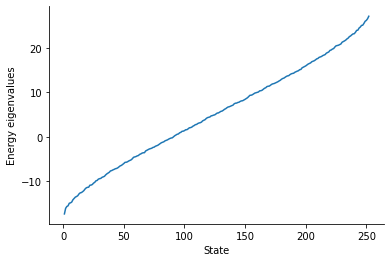

In [40]:
fig, axes = plt.subplots()
axes.plot(np.linspace(1,size,size),[H_diag[i][i] for i in range(size)])
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('State')
axes.set_ylabel('Energy eigenvalues')

In [41]:
eigenvalues_states_mapping = {}

In [42]:
for i in range(size):
    eigenvalues_states_mapping[H_diag[i][i]] = list(sorted_dict.values())[i]

In [43]:
eigenvalues_states_mapping

{-17.3891775129273: (1, 1, 1, 1, 1, 0, 0, 0, 0, 0),
 -16.129224760483265: (1, 1, 1, 1, 0, 1, 0, 0, 0, 0),
 -15.71236389857035: (1, 1, 1, 1, 0, 0, 1, 0, 0, 0),
 -15.560969856199124: (1, 1, 1, 1, 0, 0, 0, 1, 0, 0),
 -14.983038149616693: (1, 1, 1, 1, 0, 0, 0, 0, 1, 0),
 -14.895799380373662: (1, 1, 1, 0, 1, 1, 0, 0, 0, 0),
 -14.727064414829208: (1, 1, 1, 0, 1, 0, 1, 0, 0, 0),
 -14.202274329947283: (1, 1, 0, 1, 1, 1, 0, 0, 0, 0),
 -13.89415618655918: (1, 1, 0, 1, 1, 0, 1, 0, 0, 0),
 -13.601857417638389: (1, 0, 1, 1, 1, 1, 0, 0, 0, 0),
 -13.462565158349095: (1, 0, 1, 1, 1, 0, 1, 0, 0, 0),
 -13.281910699462413: (1, 1, 1, 0, 1, 0, 0, 1, 0, 0),
 -12.88296813356777: (1, 1, 0, 1, 1, 0, 0, 1, 0, 0),
 -12.643786852803839: (1, 0, 1, 1, 1, 0, 0, 1, 0, 0),
 -12.571608921513317: (1, 1, 1, 0, 1, 0, 0, 0, 1, 0),
 -12.380922098450137: (1, 1, 0, 1, 1, 0, 0, 0, 1, 0),
 -12.142129367102884: (1, 0, 1, 1, 1, 0, 0, 0, 1, 0),
 -11.777620259621772: (1, 1, 1, 1, 0, 0, 0, 0, 0, 1),
 -11.510638353619756: (0, 1, 1, 1